In [19]:
import numpy as np
import torch
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, pipeline

import pandas as pd

import ipywidgets as widgets
from IPython.display import display, clear_output

import plotly.express as px

import matplotlib.pyplot as plt

import seaborn as sns

from collections import Counter
import re
import nltk
from nltk.corpus import stopwords

from nltk.util import ngrams


In [ ]:

!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 11.0 MB/s eta 0:00:00


In [ ]:
# df_combined = pd.read_csv("../aggregated_data/combined_review_data.csv")
df_combined = pd.read_csv("combined_review_data.csv")

In [ ]:
df_combined.head()

,review,review_datetime,data_source,app_name,upvote_count,total_comments,app_rating
0,uber eats for owls? will they ever come out wi...,2025-04-20 21:51:15,Reddit,UberEats,1.0,2.0,NaN
1,serious question yall is it worth going out to...,2025-04-20 21:41:21,Reddit,UberEats,1.0,1.0,NaN
2,ubereats charged me for a successful chargebac...,2025-04-20 20:50:04,Reddit,UberEats,1.0,2.0,NaN
3,ubereats driver scammed me by buying half the ...,2025-04-20 20:48:13,Reddit,UberEats,1.0,9.0,NaN
4,ubereats why you do this? family went out of t...,2025-04-20 20:19:15,Reddit,UberEats,1.0,3.0,NaN


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126725 entries, 0 to 126724
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   review           126716 non-null  object 
 1   review_datetime  126725 non-null  object 
 2   data_source      126725 non-null  object 
 3   app_name         126725 non-null  object 
 4   upvote_count     126290 non-null  float64
 5   total_comments   21157 non-null   float64
 6   app_rating       105133 non-null  float64
dtypes: float64(3), object(4)
memory usage: 6.8+ MB


In [ ]:
df_combined.shape

(126725, 7)

## Sentiment Analysis

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

In [ ]:

sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

Device set to use cuda:0


In [ ]:
label_map = {
    "LABEL_0": "Negative",
    "LABEL_1": "Neutral",
    "LABEL_2": "Positive"
}


In [ ]:
def safe_sentiment(text):
    if pd.isna(text) or text.strip() == "":
        return "Neutral"
    try:
        # Truncate input text at tokenizer level
        result = sentiment_analyzer(
            text,
            truncation=True,
            max_length=512
        )[0]
        return label_map.get(result['label'], "UNKNOWN")
    except Exception as e:
        print(f"Error processing text: {e}")
        return "ERROR"

In [ ]:
df_combined['sentiment'] = df_combined['review'].apply(safe_sentiment)

In [ ]:
df_combined['sentiment'].value_counts()

,count
sentiment,
Negative,62305
Positive,45037
Neutral,19383


In [ ]:

# df_combined.to_csv("../aggregated_data/combined_review_data_with_sentiment.csv", index=False)
df_combined.to_csv("combined_review_data_with_sentiment.csv", index=False)

In [2]:
import pandas as pd
import numpy as np

df_combined = pd.read_csv('combined_review_data_with_sentiment.csv')

In [ ]:
df_combined.shape

(126725, 8)

In [ ]:
# STEP 1: Sort based on 'review_datetime' column
df_combined = df_combined.sort_values(by='review_datetime', ascending=True)

# STEP 2: Reset the index properly
df_combined = df_combined.reset_index(drop=True)

# STEP 3: Check
print(df_combined.head())
print(df_combined.tail())


                                              review      review_datetime  \
0  When I first installed Uber Eats I was having ...  2024-04-20 07:08:47   
1  Never an issue. You find wear you want. You ge...  2024-04-20 21:45:56   
2  I would rate them negative 10. It is a matter ...  2024-04-20 21:54:04   
3  Worse app, ordered food and driver steals the ...  2024-04-20 22:01:00   
4                 Fed,drunk,happy,goodnight people 😄  2024-04-20 22:04:33   

   data_source  app_name  upvote_count  total_comments  app_rating sentiment  
0    App Store  UberEats           NaN             NaN         NaN  Negative  
1  Google Play  UberEats           0.0             NaN         5.0  Positive  
2  Google Play  UberEats           3.0             NaN         1.0  Negative  
3  Google Play  UberEats           0.0             NaN         1.0  Negative  
4  Google Play  UberEats           0.0             NaN         5.0  Positive  
                                                   review  \
12

In [ ]:
# Dropdown to select an App
app_dropdown = widgets.Dropdown(
    options=['UberEats', 'DoorDash', 'GrubHub'],
    description='Select App:',
    disabled=False,
)

# Button to trigger the plot
run_button = widgets.Button(
    description='Plot Sentiment',
    button_style='success'
)

# Output widget (for clean display)
output = widgets.Output()


In [14]:
import matplotlib.pyplot as plt

def plot_sentiment_distribution(selected_app):
    # Filter your dataframe based on app
    filtered_df = df[df['app_name'] == selected_app]

    # Plotting
    sentiment_counts = filtered_df['sentiment'].value_counts()
    sentiment_counts.plot(kind='bar')

    plt.title(f'Sentiment Distribution for {selected_app}')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.grid(True)
    plt.show()


In [13]:
# -----------------------------------------
# DATA CLEANING
# -----------------------------------------

# Assuming df_combined is already loaded
# (If not, load it: df_combined = pd.read_csv('your_file.csv'))

# Step 1: Properly clean app names
df_combined['app_name'] = df_combined['app_name'].str.strip().str.title()
df_combined['app_name'] = df_combined['app_name'].replace({
    'Ubereats': 'UberEats',
    'Doordash': 'DoorDash',
    'Grubhub': 'GrubHub'
})

# Step 2: Clean sentiment column
df_combined['sentiment'] = df_combined['sentiment'].str.lower()

# Step 3: Define app colors
app_colors = {
    'UberEats': {
        'neutral': '#90EE90',  # Light Green
        'positive': '#32CD32', # Medium Green
        'negative': '#006400', # Dark Green
    },
    'DoorDash': {
        'neutral': '#FFB6C1',  # Light Red
        'positive': '#FF6347', # Tomato Red
        'negative': '#8B0000', # Dark Red
    },
    'GrubHub': {
        'neutral': '#FFDAB9',  # Light Orange
        'positive': '#FFA500', # Orange
        'negative': '#FF8C00', # Dark Orange
    }
}

# -----------------------------------------
# FUNCTION TO PLOT DONUT CHART
# -----------------------------------------

def plot_donut_for_app(selected_app):
    # Filter only for selected app
    app_df = df_combined[df_combined['app_name'] == selected_app]

    # Count sentiments
    sentiment_counts = app_df['sentiment'].value_counts()
    sentiments = ['neutral', 'positive', 'negative']
    counts = [sentiment_counts.get(sentiment, 0) for sentiment in sentiments]

    # Check if there is data
    if sum(counts) == 0:
        print(f'⚠️ No data for {selected_app}')
        return

    # Select correct colors
    colors = [app_colors[selected_app][sentiment] for sentiment in sentiments]

    # Plot donut pie chart
    fig, ax = plt.subplots(figsize=(6, 6))
    wedges, texts, autotexts = ax.pie(
        counts,
        labels=sentiments,
        colors=colors,
        autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
        startangle=140,
        wedgeprops=dict(width=0.4)
    )

    # Add center circle for donut shape
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    ax.set_title(f'Sentiment Distribution for {selected_app}', fontsize=16)
    plt.show()

# -----------------------------------------
# WIDGETS SETUP
# -----------------------------------------

# Dropdown to select App
app_dropdown = widgets.Dropdown(
    options=['UberEats', 'DoorDash', 'GrubHub'],
    description='Select App:',
    disabled=False,
)

# Button to trigger the plot
run_button = widgets.Button(
    description='Plot Sentiment Donut',
    button_style='info'  # 'success', 'info', 'warning', 'danger'
)

# Output widget
output = widgets.Output()

# Function that runs when button is clicked
def on_run_button_clicked(b):
    with output:
        clear_output()
        selected_app = app_dropdown.value
        plot_donut_for_app(selected_app)

# Connect button to function
run_button.on_click(on_run_button_clicked)

# -----------------------------------------
# DISPLAY WIDGETS
# -----------------------------------------

display(app_dropdown, run_button, output)


Dropdown(description='Select App:', options=('UberEats', 'DoorDash', 'GrubHub'), value='UberEats')

Button(button_style='info', description='Plot Sentiment Donut', style=ButtonStyle())

Output()

This visualization shows the sentiment breakdown such as positive, neutral, negative of user reviews for a selected app (UberEats, DoorDash, or GrubHub).

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


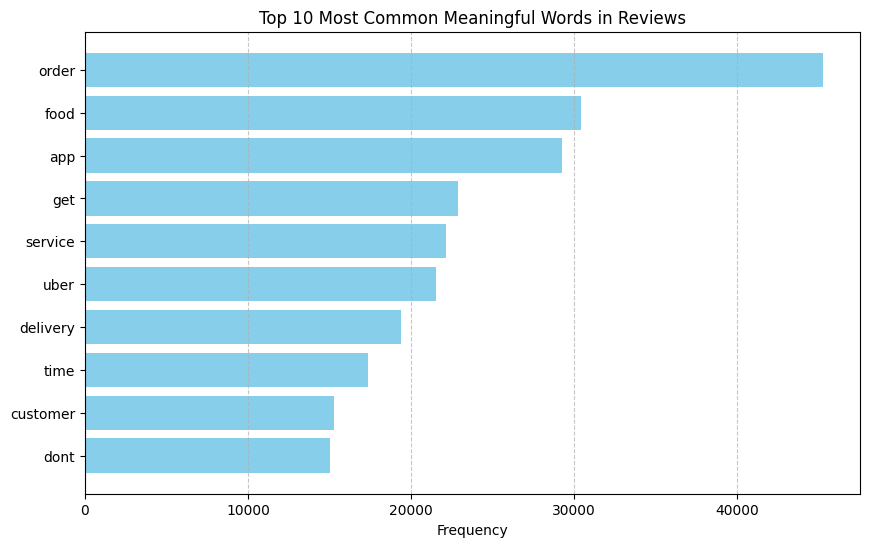

In [ ]:


# Download NLTK stopwords (only once)
nltk.download('stopwords')

# Step 1: Combine all reviews into one big text
all_reviews = ' '.join(df_combined['review'].dropna().astype(str))

# Step 2: Clean the text
all_reviews = all_reviews.lower()
all_reviews = re.sub(r'[^a-z\s]', '', all_reviews)

# Step 3: Tokenize into words
words = all_reviews.split()

# Step 4: Remove stopwords
stop_words = set(stopwords.words('english'))
filtered_words = [word for word in words if word not in stop_words]

# Step 5: Count word frequencies
word_counts = Counter(filtered_words)

# Step 6: Get top 10 most common words
top_10 = word_counts.most_common(10)
words, counts = zip(*top_10)

# Step 7: Plot horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color='skyblue')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common Meaningful Words in Reviews')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# The aobve plot give the frequency count of the top 10 words used in the reviews acroos all platforms

In [15]:

# Download stopwords
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define apps
apps = ['UberEats', 'DoorDash', 'GrubHub']

# Define colors for each app
app_colors = {
    'UberEats': 'green',
    'DoorDash': 'red',
    'GrubHub': 'orange'
}

# -----------------------------------
# FUNCTION TO PLOT BAR CHART FOR ONE APP
# -----------------------------------

def plot_top_words(selected_app):
    # Step 1: Filter reviews for the selected app
    app_reviews = df_combined[df_combined['app_name'] == selected_app]['review'].dropna().astype(str)
    combined_reviews = ' '.join(app_reviews)

    # Step 2: Clean the text
    combined_reviews = combined_reviews.lower()
    combined_reviews = re.sub(r'[^a-z\s]', '', combined_reviews)

    # Step 3: Tokenize
    words = combined_reviews.split()

    # Step 4: Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Step 5: Count and get top 10
    word_counts = Counter(filtered_words)
    top_10 = word_counts.most_common(10)

    if len(top_10) > 0:
        top_words, top_counts = zip(*top_10)
    else:
        top_words, top_counts = [], []

    # Step 6: Plot
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.barh(top_words, top_counts, color=app_colors[selected_app])
    ax.set_title(f'{selected_app} - Top 10 Words', fontsize=16)
    ax.set_xlabel('Frequency')
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    plt.show()

# -----------------------------------
# WIDGET SETUP
# -----------------------------------

# Dropdown for app selection
app_dropdown = widgets.Dropdown(
    options=apps,
    description='Select App:',
    disabled=False,
)

# Button to trigger plot
run_button = widgets.Button(
    description='Plot Top Words',
    button_style='success'
)

# Output widget
output = widgets.Output()

# Function triggered on button click
def on_run_button_clicked(b):
    with output:
        clear_output()
        selected_app = app_dropdown.value
        plot_top_words(selected_app)

# Connect button to function
run_button.on_click(on_run_button_clicked)

# Display widgets
display(app_dropdown, run_button, output)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Dropdown(description='Select App:', options=('UberEats', 'DoorDash', 'GrubHub'), value='UberEats')

Button(button_style='success', description='Plot Top Words', style=ButtonStyle())

Output()

The above pie chart give the distribution of the sentiments across different platforms by the users

In [ ]:
# Download stopwords
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Define apps
apps = ['UberEats', 'DoorDash', 'GrubHub']

# Define color maps for each app
app_colormaps = {
    'UberEats': 'Greens',    # shades of green
    'DoorDash': 'Reds',      # shades of red
    'GrubHub': 'Oranges'     # shades of orange
}

# --------------------------------------------
# Function to plot WordCloud for selected app
def plot_wordcloud_for_app(selected_app):
    # Step 1: Filter reviews for this app
    app_reviews = df_combined[df_combined['app_name'] == selected_app]['review'].dropna().astype(str)
    combined_reviews = ' '.join(app_reviews)

    # Step 2: Clean text
    combined_reviews = combined_reviews.lower()
    combined_reviews = re.sub(r'[^a-z\s]', '', combined_reviews)

    # Step 3: Tokenize
    words = combined_reviews.split()

    # Step 4: Remove stopwords
    filtered_words = [word for word in words if word not in stop_words]

    # Step 5: Count word frequencies
    word_counts = Counter(filtered_words)

    if len(word_counts) == 0:
        print(f"No data available for {selected_app}")
        return

    # Step 6: Create WordCloud
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='white',
        colormap=app_colormaps[selected_app],  # dynamic color
        max_words=100,
        contour_width=0,
        scale=3,
        prefer_horizontal=1.0
    ).generate_from_frequencies(word_counts)

    # Step 7: Plot
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{selected_app} - Word Cloud', fontsize=20)
    plt.show()

# --------------------------------------------
# WIDGET SETUP

# Dropdown for app selection
app_dropdown = widgets.Dropdown(
    options=apps,
    description='Select App:',
    disabled=False,
)

# Button to trigger plot
run_button = widgets.Button(
    description='Plot WordCloud',
    button_style='success'
)

# Output widget
output = widgets.Output()

# Function triggered on button click
def on_run_button_clicked(b):
    with output:
        clear_output()
        selected_app = app_dropdown.value
        plot_wordcloud_for_app(selected_app)

# Connect button to function
run_button.on_click(on_run_button_clicked)

# Display widgets
display(app_dropdown, run_button, output)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Dropdown(description='Select App:', options=('UberEats', 'DoorDash', 'GrubHub'), value='UberEats')

Button(button_style='success', description='Plot WordCloud', style=ButtonStyle())

Output()

This WordCloud represents the most frequently mentioned words in user reviews for a selected app (UberEats, DoorDash, or GrubHub).

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


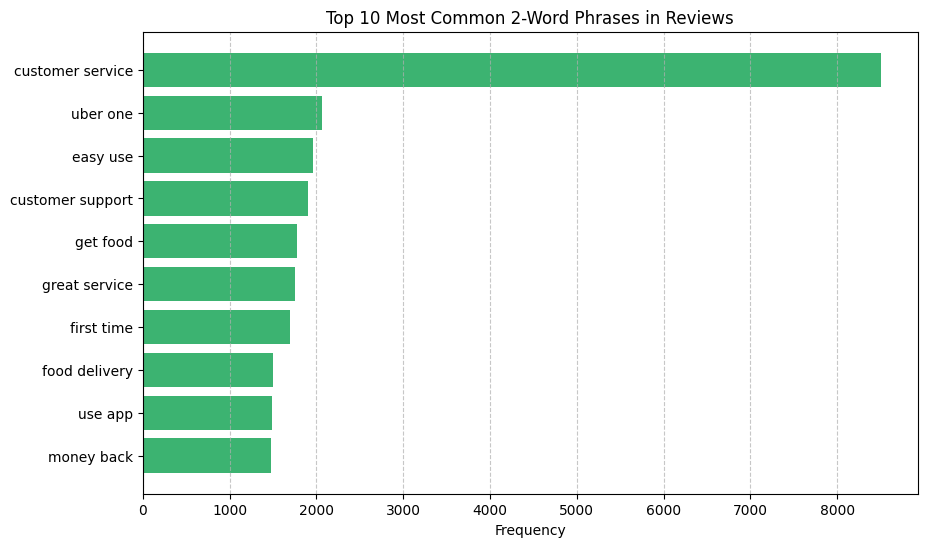

In [20]:

# Download NLTK stopwords (only once)
nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

# Step 0: Combine all reviews
all_reviews = ' '.join(df_combined['review'].dropna().astype(str))

# Special Replace app names
all_reviews = all_reviews.lower()
all_reviews = all_reviews.replace('uber eats', 'ubereats')
all_reviews = all_reviews.replace('door dash', 'doordash')
all_reviews = all_reviews.replace('grub hub', 'grubhub')

# Step 1: Clean the text
all_reviews = re.sub(r'[^a-z\s]', '', all_reviews)

# Step 2: Tokenize
words = all_reviews.split()

# Step 3: Remove stopwords
filtered_words = [word for word in words if word not in stop_words]

# Step 4: Create 2-grams
bigrams = list(ngrams(filtered_words, 2))

# Step 5: Count bigrams
bigram_counts = Counter(bigrams)

# 🔥 Step 6: Get Top 10 bigrams
top_10_bigrams = bigram_counts.most_common(10)

# 🔥 Step 7: Prepare phrases and counts
phrases = [' '.join(bigram) for bigram, count in top_10_bigrams]
counts = [count for bigram, count in top_10_bigrams]

# 🔥 Step 8: Plot
plt.figure(figsize=(10, 6))
plt.barh(phrases, counts, color='mediumseagreen')
plt.xlabel('Frequency')
plt.title('Top 10 Most Common 2-Word Phrases in Reviews')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


# This visualization identifies and displays the most frequent 2-word combinations (also called bigrams) found across all user reviews in the dataset.

In [16]:


# --------------------------------------------
# Step 1: Create Dropdown for Data Source
source_dropdown = widgets.Dropdown(
    options=df_combined['data_source'].unique().tolist(),
    description='Source:',
    disabled=False,
)

# Button to plot
plot_button = widgets.Button(
    description='Plot Sentiment Pie',
    button_style='success'
)

# Output widget
output = widgets.Output()

# --------------------------------------------
# Step 2: Define function to plot Pie Chart
def plot_pie_for_source(selected_source):
    # Filter data for selected source
    source_df = df_combined[df_combined['data_source'] == selected_source]

    # Count sentiments
    sentiment_counts = source_df['sentiment'].value_counts()

    if sentiment_counts.empty:
        print(f"No data for {selected_source}")
        return

    # Plot Pie Chart
    fig, ax = plt.subplots(figsize=(6,6))
    ax.pie(
        sentiment_counts,
        labels=sentiment_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Set2.colors  # same Set2 color palette
    )

    ax.set_title(f'Sentiment Distribution for {selected_source}', fontsize=16)
    plt.show()

# --------------------------------------------
# Step 3: Button click connection
def on_plot_button_clicked(b):
    with output:
        clear_output()
        selected_source = source_dropdown.value
        plot_pie_for_source(selected_source)

plot_button.on_click(on_plot_button_clicked)

# --------------------------------------------
# Step 4: Display Widgets
display(source_dropdown, plot_button, output)


Dropdown(description='Source:', options=('Reddit', 'Google Play', 'App Store'), value='Reddit')

Button(button_style='success', description='Plot Sentiment Pie', style=ButtonStyle())

Output()

# This interactive pie chart shows the sentiment breakdown (positive, neutral, negative) of user reviews from a selected data source (Reddit, App Store, or Google Play).

In [18]:


# --------------------------------------------
# Step 1: Setup Data
sources = df_combined['data_source'].unique()

# Source Dropdown widget
source_dropdown = widgets.Dropdown(
    options=sources,
    description='Select Source:',
    disabled=False,
)

# Button to plot
plot_button = widgets.Button(
    description='Plot Sentiment Pie',
    button_style='success'
)

# Output widget
output = widgets.Output()

# --------------------------------------------
# Step 2: Define function to plot donut pie
def plot_sentiment_pie(selected_source):
    source_df = df_combined[df_combined['data_source'] == selected_source]

    # Count sentiments
    sentiment_counts = source_df['sentiment'].value_counts()
    sentiments = ['positive', 'neutral', 'negative']
    counts = [sentiment_counts.get(sentiment, 0) for sentiment in sentiments]

    # Plot
    fig, ax = plt.subplots(figsize=(6,6))

    wedges, texts, autotexts = ax.pie(
        counts,
        labels=sentiments,
        autopct=lambda p: f'{p:.1f}%' if p > 0 else '',
        startangle=140,
        colors=['limegreen', 'lightgrey', 'tomato'],
        wedgeprops=dict(width=0.4)  # Donut
    )

    # Center circle for donut
    centre_circle = plt.Circle((0, 0), 0.70, fc='white')
    ax.add_artist(centre_circle)

    ax.set_title(f'Sentiment Distribution - {selected_source}', fontsize=16)
    plt.tight_layout()
    plt.show()

# --------------------------------------------
# Step 3: Button click handler
def on_plot_button_clicked(b):
    with output:
        clear_output()
        selected_source = source_dropdown.value
        plot_sentiment_pie(selected_source)

plot_button.on_click(on_plot_button_clicked)

# --------------------------------------------
# Step 4: Display widgets
display(source_dropdown, plot_button, output)


Dropdown(description='Select Source:', options=('Reddit', 'Google Play', 'App Store'), value='Reddit')

Button(button_style='success', description='Plot Sentiment Pie', style=ButtonStyle())

Output()

# This visualization represents the distribution of sentiments (positive, neutral, negative) for reviews collected from different sources like Reddit, Google Play, or App Store, shown in the form of a donut chart.